Highly correlated features (correlation > 0.9) to be removed:
FlowReceivedRate: ['FlowSentRate'] - Correlation values: [0.9537049]
PacketLengthStandardDeviation: ['PacketLengthVariance'] - Correlation values: [0.93373698]
PacketLengthCoefficientofVariation: ['PacketLengthStandardDeviation'] - Correlation values: [0.93590212]
PacketTimeStandardDeviation: ['Duration', 'PacketTimeVariance'] - Correlation values: [0.94321258 0.94305579]
PacketTimeMean: ['Duration', 'PacketTimeStandardDeviation'] - Correlation values: [0.92394527 0.92297483]
PacketTimeMedian: ['PacketTimeMean'] - Correlation values: [0.98639103]
ResponseTimeTimeStandardDeviation: ['ResponseTimeTimeVariance'] - Correlation values: [0.95390139]
ResponseTimeTimeMedian: ['ResponseTimeTimeMean'] - Correlation values: [0.97528985]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]



Selected features: ['ResponseTimeTimeSkewFromMode', 'Duration', 'PacketLengthMode', 'PacketLengthMean', 'PacketTimeSkewFromMedian', 'FlowSentRate', 'ResponseTimeTimeSkewFromMedian', 'PacketLengthVariance', 'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation', 'PacketLengthSkewFromMedian', 'FlowBytesReceived', 'ResponseTimeTimeCoefficientofVariation', 'FlowBytesSent', 'ResponseTimeTimeMean', 'ResponseTimeTimeMode', 'PacketTimeMode', 'ResponseTimeTimeVariance', 'PacketLengthMedian', 'PacketTimeVariance']

Cross-validation scores: [0.99968477 0.99985166 0.99983311 0.99632844 0.99708871]
Mean cross-validation score: 0.9985573380450177
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 

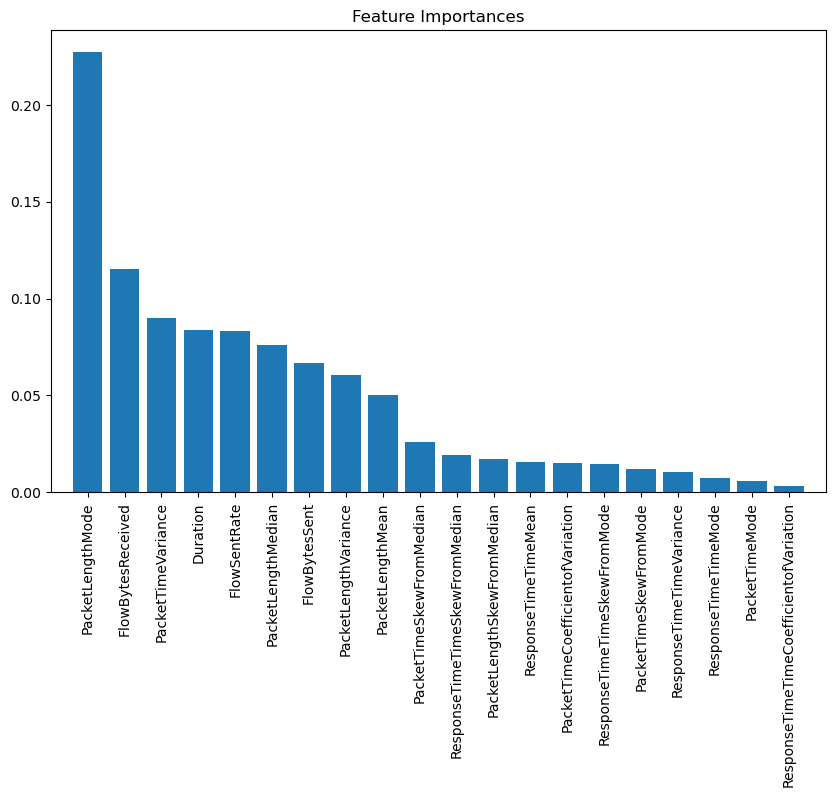

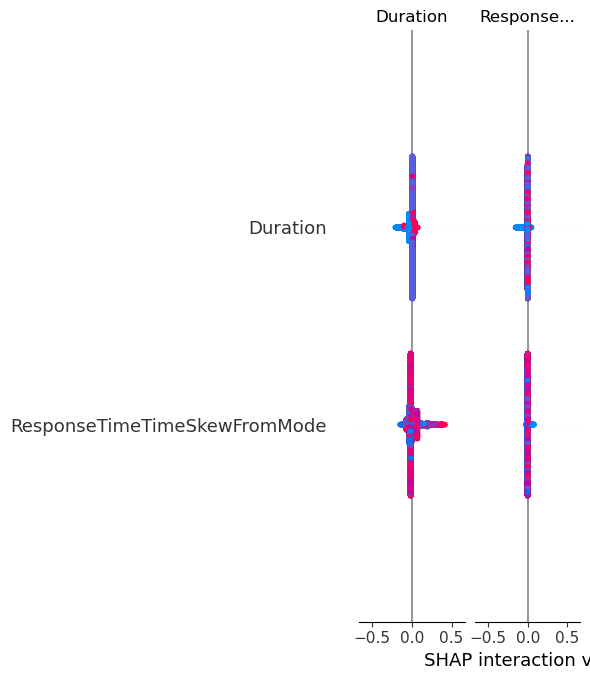

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from mrmr import mrmr_classif

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# Load the datasets (replace 'l2-benign.csv' and 'l2-malicious.csv' with your actual filenames)
benign_data = pd.read_csv('l2-benign.csv')
malicious_data = pd.read_csv('l2-malicious.csv')

# Combine benign and malicious datasets
data = pd.concat([benign_data, malicious_data], ignore_index=True)

# Drop unnecessary columns
columns_to_drop = ['SourceIP', 'SourcePort', 'DestinationIP', 'DestinationPort', 'TimeStamp']
data = data.drop(columns_to_drop, axis=1)

# Separate features and target
X = data.drop('Label', axis=1)
y = data['Label']

# Encode categorical target variable 'Label'
le = LabelEncoder()
y = le.fit_transform(y)

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Feature scaling (if needed)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Find the correlation matrix
correlation_matrix = X_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('Highly correlated features (correlation > 0.9) to be removed:')
for feature in to_drop:
    corr_values = upper[feature][upper[feature] > 0.9]
    print(f'{feature}: {corr_values.index.tolist()} - Correlation values: {corr_values.values}')

# Drop highly correlated features
X_scaled = X_scaled.drop(columns=to_drop)

# Apply mRMR feature selection
selected_features = mrmr_classif(X_scaled, y, K=20)  # Adjust K to select the desired number of features

print('\nSelected features:', selected_features)

# Reduce dataset to selected features
X_selected = X_scaled[selected_features]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Cross-validation
scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42), X_selected, y, cv=5, scoring='accuracy')
print(f'\nCross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

print(f'\nBest parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

# Train RandomForest classifier with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate model
y_pred = best_rf.predict(X_test)

# Convert predictions back to original labels
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

print('\nAccuracy:', accuracy_score(y_test_original, y_pred_original))
print('Classification Report:')
print(classification_report(y_test_original, y_pred_original))

# Print confusion matrix
print('\nConfusion Matrix:')
print(confusion_matrix(y_test_original, y_pred_original))

# Feature importance analysis
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_selected.shape[1]), importances[indices], align="center")
plt.xticks(range(X_selected.shape[1]), [X_selected.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X_selected.shape[1]])
plt.show()

# Model interpretation with SHAP
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)
